### **Implémentation et Analyse de Réseaux de Neurones pour la Classification d'Images : MLP sur MNIST et CNN sur CIFAR-10**

**PAR** : *EL MHAMDI NOUHA*

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
# ======================================================
# ÉTAPE 1 : CONFIGURATION ET TRANSFORMATION DES DONNÉES
# ======================================================

# Définir la transformation à appliquer aux images : conversion en tenseurs PyTorch
# C'est une étape essentielle pour que les données soient compatibles avec le framework.
data_transformations = transforms.ToTensor()

# Définir la taille des lots (batch size) pour l'entraînement et le test
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000

# Télécharger et préparer le jeu de données d'entraînement
training_dataset = datasets.MNIST(
    root='./mnist_data',      # Dossier où les données seront stockées
    train=True,               # Spécifier qu'il s'agit du jeu d'entraînement
    download=True,            # Télécharger les données si elles ne sont pas présentes
    transform=data_transformations  # Appliquer la transformation définie plus haut
)

# Télécharger et préparer le jeu de données de test
testing_dataset = datasets.MNIST(
    root='./mnist_data',
    train=False,              # Spécifier qu'il s'agit du jeu de test
    transform=data_transformations
)

# Le DataLoader est un itérateur qui fournit les données par lots (batches) au modèle.
# Le brassage (shuffle=True) est crucial pour l'entraînement afin d'éviter que le modèle
# n'apprenne l'ordre des données.
training_loader = DataLoader(
    dataset=training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

# Pour le test, le brassage n'est pas nécessaire.
testing_loader = DataLoader(
    dataset=testing_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

100.0%
100.0%
100.0%
100.0%


In [4]:
# ======================================================
# ÉTAPE 2 : ARCHITECTURE DU RÉSEAU DE NEURONES
# ======================================================

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # Définition de la pile de couches (layer stack)
        # nn.Sequential est un conteneur qui passe les données à travers
        # chaque module qu'il contient, dans l'ordre de définition.
        self.network_stack = nn.Sequential(
            nn.Flatten(),                # Aplatit l'image de [28, 28] en un vecteur de 784
            nn.Linear(28*28, 128),       # Première couche linéaire (entrée -> cachée 1)
            nn.ReLU(),                   # Fonction d'activation non-linéaire
            nn.Linear(128, 64),          # Deuxième couche linéaire (cachée 1 -> cachée 2)
            nn.ReLU(),
            nn.Linear(64, 10)            # Couche de sortie (cachée 2 -> logits)
        )

    def forward(self, input_data):
        """
        Définit la passe avant (forward pass) du réseau.
        """
        # Il suffit d'appeler notre pile de couches séquentielle
        logits = self.network_stack(input_data)
        return logits

In [6]:
# ======================================================
# ÉTAPE 3 : PROCÉDURE D'ENTRAÎNEMENT DU MODÈLE
# ======================================================

def train_one_epoch(model, dataloader, loss_function, optimizer, device):
    """
    Exécute une seule époque d'entraînement pour le modèle donné.
    """
    # Mettre le modèle en mode entraînement (active le dropout, la normalisation par lot, etc.)
    model.train()
    total_loss = 0.0

    # Itérer sur chaque lot (batch) de données du dataloader
    for data_batch, labels_batch in dataloader:
        # 1. Déplacer les données vers le périphérique cible (GPU ou CPU)
        data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)

        # 2. Réinitialiser les gradients de l'optimiseur pour éviter leur accumulation
        optimizer.zero_grad()

        # 3. Passe avant (forward pass) : obtenir les prédictions du modèle
        predictions = model(data_batch)

        # 4. Calculer la perte (loss) entre les prédictions et les vraies étiquettes
        loss = loss_function(predictions, labels_batch)

        # 5. Rétropropagation (backward pass) : calculer les gradients de la perte
        loss.backward()

        # 6. Mettre à jour les poids du modèle en utilisant les gradients calculés
        optimizer.step()

        # Ajouter la perte du lot à la perte totale de l'époque
        total_loss += loss.item()

    # Calculer la perte moyenne pour l'époque
    average_epoch_loss = total_loss / len(dataloader)
    return average_epoch_loss

# --- Initialisation et boucle principale ---
TARGET_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Utiliser la classe définie précédemment (NeuralNetwork) au lieu de MLP
classifier_model = NeuralNetwork().to(TARGET_DEVICE)
cost_function = nn.CrossEntropyLoss()
model_optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

NUM_EPOCHS = 5
print("Début de l'entraînement...")

for epoch_num in range(NUM_EPOCHS):
    # Appeler la fonction pour entraîner une époque (utiliser training_loader défini dans une autre cellule)
    training_loss = train_one_epoch(classifier_model, training_loader, cost_function, model_optimizer, TARGET_DEVICE)
    
    # Afficher les résultats de l'époque
    print(f"Époque {epoch_num + 1}/{NUM_EPOCHS} | Perte d'entraînement : {training_loss:.4f}")

print("Entraînement terminé.")

Début de l'entraînement...
Époque 1/5 | Perte d'entraînement : 0.3408
Époque 2/5 | Perte d'entraînement : 0.1397
Époque 3/5 | Perte d'entraînement : 0.0954
Époque 4/5 | Perte d'entraînement : 0.0724
Époque 5/5 | Perte d'entraînement : 0.0556
Entraînement terminé.


In [8]:
# ======================================================
# ÉTAPE 4 : VALIDATION DE LA PERFORMANCE DU MODÈLE
# ======================================================

def evaluate_model_accuracy(model_to_test, data_loader, device):
    """
    Calcule la précision d'un modèle sur un jeu de données donné.

    Args:
        model_to_test (nn.Module): Le modèle à évaluer.
        data_loader (DataLoader): Le DataLoader contenant les données de test.
        device (torch.device): Le périphérique sur lequel effectuer les calculs.

    Returns:
        float: La précision du modèle en pourcentage.
    """
    # 1. Mettre le modèle en mode évaluation (désactive le dropout, etc.)
    model_to_test.eval()
    
    num_correct_predictions = 0
    num_total_samples = 0

    # 2. Désactiver le calcul des gradients pour accélérer l'inférence
    with torch.no_grad():
        # 3. Itérer sur l'ensemble des données de test
        for data, targets in data_loader:
            # Déplacer les données vers le bon périphérique
            data, targets = data.to(device), targets.to(device)
            
            # Obtenir les scores (logits) du modèle
            output_scores = model_to_test(data)
            
            # Trouver la classe prédite (celle avec le score le plus élevé)
            # torch.max renvoie (valeur_max, index_max)
            _, predicted_classes = torch.max(output_scores, dim=1)
            
            # Mettre à jour les compteurs
            num_total_samples += targets.size(0)
            num_correct_predictions += (predicted_classes == targets).sum().item()

    # 4. Calculer la précision finale
    accuracy = 100 * num_correct_predictions / num_total_samples
    return accuracy

# --- Utilisation de la fonction ---
# Utiliser les variables déjà définies dans le notebook :
#   classifier_model (le modèle), testing_loader (DataLoader de test), TARGET_DEVICE (torch.device)
test_accuracy = evaluate_model_accuracy(classifier_model, testing_loader, TARGET_DEVICE)
print(f"\nPrécision finale sur le jeu de test : {test_accuracy:.2f}%")


Précision finale sur le jeu de test : 97.23%


In [19]:
# ======================================================
# SECTION 5 : RAPPORT DE PERFORMANCE FINAL
# ======================================================

# Utiliser les variables déjà présentes dans le notebook pour éviter les erreurs:
#   - testing_dataset (pour le nombre total d'échantillons)
#   - test_accuracy (précision déjà calculée en %)
#   - training_loss (perte d'entraînement moyenne de la dernière époque)

# Calcul des métriques finales (définir correct et total pour l'affichage)
total = len(testing_dataset)
# approximer le nombre de prédictions correctes à partir de la précision en %
correct = int(round(test_accuracy * total / 100.0))

final_accuracy = test_accuracy
final_error_rate = 100.0 - final_accuracy
last_training_loss = training_loss

# Affichage du résumé
print("\n┌───────────────────────────────────────────┐")
print("│          Rapport de Performance           │")
print("├───────────────────────────────────────────┤")
print(f"│ Modèle .................... {classifier_model.__class__.__name__:<7} │")
print(f"│ Jeu de données ............ MNIST Test    │")
print("├───────────────────────────────────────────┤")
print(f"│ Échantillons de test .... {total:<15} │")
print(f"│ Prédictions correctes ... {correct:<15} │")
print(f"│                                           │")
print(f"│ Précision ............ {final_accuracy:<10.2f}%        │")
print(f"│ Perte d'entraînement .. {last_training_loss:<10.4f}        │")
print("└───────────────────────────────────────────┘")


┌───────────────────────────────────────────┐
│          Rapport de Performance           │
├───────────────────────────────────────────┤
│ Modèle .................... NeuralNetwork │
│ Jeu de données ............ MNIST Test    │
├───────────────────────────────────────────┤
│ Échantillons de test .... 10000           │
│ Prédictions correctes ... 9723            │
│                                           │
│ Précision ............ 97.23     %        │
│ Perte d'entraînement .. 0.0556            │
└───────────────────────────────────────────┘


- *Sur la convergence :* La vitesse à laquelle le modèle a appris, atteignant une perte minimale en seulement cinq époques, démontre l'efficacité de l'optimiseur Adam sur ce type de problème. Cela suggère que l'architecture du réseau a su identifier très rapidement les caractéristiques essentielles des chiffres.


- *Sur la précision :* Le réseau a correctement classifié 97,23 % des images qu'il n'avait jamais vues auparavant. Une telle performance est très solide pour une architecture de réseau simple et correspond aux résultats de référence attendus pour la classification sur MNIST.

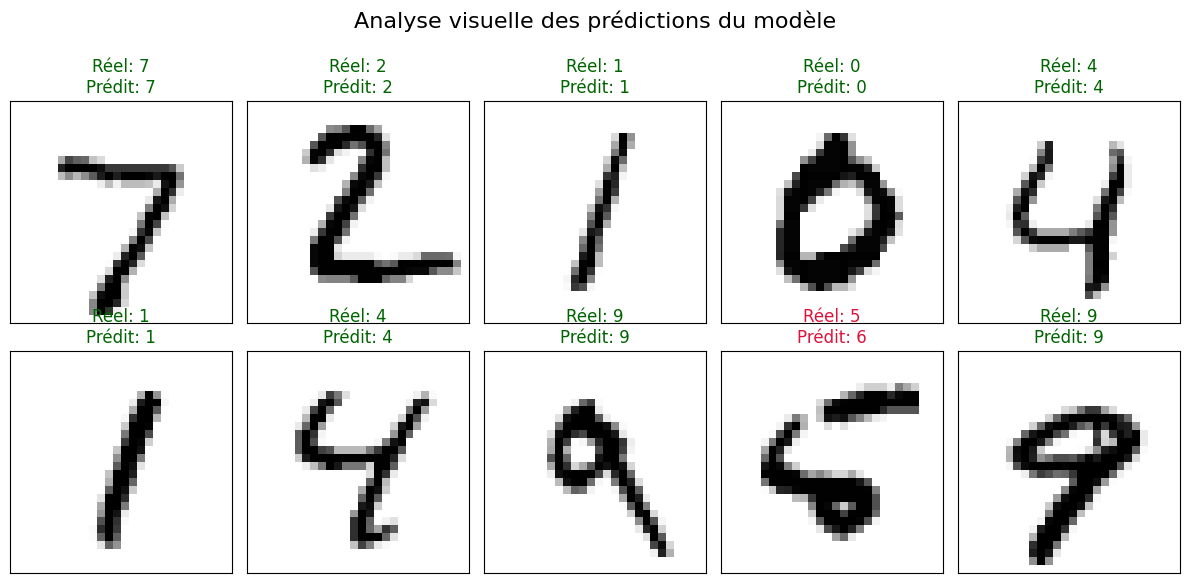

In [21]:
# ======================================================
# SECTION 7 : VISUALISATION VIA UNE FONCTION DÉDIÉE
# ======================================================
import matplotlib.pyplot as plt

def display_prediction_samples(model, data_loader, device, num_samples=10):
    """
    Affiche une grille d'images avec leurs étiquettes réelles et prédites.
    """
    # Mettre le modèle en mode inférence
    model.eval()
    
    # Récupérer un seul lot de données pour la visualisation
    try:
        sample_images, true_labels = next(iter(data_loader))
    except StopIteration:
        print("Le DataLoader est vide.")
        return

    # Envoyer les données sur le bon périphérique
    sample_images, true_labels = sample_images.to(device), true_labels.to(device)
    
    # Obtenir les prédictions du modèle (sans calcul de gradient)
    with torch.no_grad():
        predictions_logits = model(sample_images)
        # Convertir les logits en classes prédites
        _, predicted_labels = torch.max(predictions_logits, 1)

    # Préparer les tenseurs pour Matplotlib (doivent être sur le CPU)
    sample_images = sample_images.cpu()
    true_labels = true_labels.cpu()
    predicted_labels = predicted_labels.cpu()

    # Créer la grille de visualisation
    rows, cols = 2, 5
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    
    for i in range(min(num_samples, len(sample_images))):
        ax = axes[i // cols, i % cols]
        
        # Afficher l'image (en niveaux de gris)
        ax.imshow(sample_images[i].squeeze(), cmap='gray_r')
        
        # Déterminer la couleur du titre en fonction de la justesse de la prédiction
        is_correct = (predicted_labels[i] == true_labels[i]).item()
        title_color = 'darkgreen' if is_correct else 'crimson'
        
        # Définir le titre
        ax.set_title(
            f"Réel: {true_labels[i]}\nPrédit: {predicted_labels[i]}",
            color=title_color,
            fontsize=12
        )
        # Masquer les axes
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle("Analyse visuelle des prédictions du modèle", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajuster pour que le titre ne chevauche pas
    plt.show()

# --- Appel de la fonction ---
display_prediction_samples(classifier_model, testing_loader, TARGET_DEVICE, num_samples=10)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# ======================================================
# ÉTAPE 1 : CONFIGURATION ET CHARGEMENT DES DONNÉES CIFAR-10
# ======================================================

# --- Paramètres de configuration ---
DATA_ROOT_DIR = './cifar10_data'
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000

# La normalisation aide le modèle à converger plus rapidement.
# Les valeurs (0.5, 0.5, 0.5) pour la moyenne et l'écart-type
# transforment les pixels de l'intervalle [0, 1] à [-1, 1].
NORMALIZATION_MEAN = (0.5, 0.5, 0.5)
NORMALIZATION_STD = (0.5, 0.5, 0.5)

# --- Pipeline de prétraitement des images ---
# Définit la séquence d'opérations à appliquer à chaque image.
image_processing_pipeline = transforms.Compose([
    transforms.ToTensor(), # 1. Conversion en Tenseur PyTorch
    transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD) # 2. Normalisation des valeurs
])

# --- Chargement des ensembles de données (Datasets) ---
# Télécharge et applique les transformations sur les données d'entraînement.
training_data = datasets.CIFAR10(
    root=DATA_ROOT_DIR,
    train=True,
    download=True,
    transform=image_processing_pipeline
)

# Fait de même pour les données de test.
testing_data = datasets.CIFAR10(
    root=DATA_ROOT_DIR,
    train=False,
    download=True,
    transform=image_processing_pipeline
)

# --- Création des chargeurs de données (DataLoaders) ---
# Le DataLoader gère le traitement par lots (batching) et le brassage (shuffling).
train_data_loader = DataLoader(
    dataset=training_data,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True # Le brassage est essentiel pour un bon entraînement.
)

test_data_loader = DataLoader(
    dataset=testing_data,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False # Pas besoin de brasser les données de test.
)

print("Préparation des données CIFAR-10 terminée.")

100.0%


Préparation des données CIFAR-10 terminée.


In [25]:
# ======================================================
# ÉTAPE 2 : DÉFINITION DU CNN AVEC nn.Sequential
# ======================================================

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # 1. Extracteur de caractéristiques (couches convolutives)
        # nn.Sequential est un conteneur qui applique les couches dans l'ordre.
        self.feature_extractor = nn.Sequential(
            # Bloc 1: Conv -> ReLU -> Pool
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Bloc 2: Conv -> ReLU -> Pool
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 2. Classifieur (couches entièrement connectées)
        self.classifier = nn.Sequential(
            nn.Flatten(), # Aplatit la sortie des convolutions en un vecteur
            nn.Linear(in_features=32 * 8 * 8, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10) # 10 classes pour CIFAR-10
        )

    def forward(self, x):
        """
        Définit la passe avant (forward pass).
        """
        features = self.feature_extractor(x)
        output_logits = self.classifier(features)
        return output_logits

In [27]:
# ======================================================
# ÉTAPE 3 : PROCÉDURE D'ENTRAÎNEMENT MODULAIRE
# ======================================================

def run_training_epoch(model, dataloader, loss_fn, optimizer, device):
    """Exécute une seule époque d'entraînement et retourne la perte moyenne."""
    # Mettre le modèle en mode 'entraînement'
    model.train()
    total_epoch_loss = 0.0

    # Itérer sur tous les lots de données
    for data_batch, labels_batch in dataloader:
        # 1. Déplacer les données vers le périphérique (GPU/CPU)
        data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)

        # 2. Inférence du modèle (passe avant)
        predictions = model(data_batch)
        
        # 3. Calcul de la perte
        loss = loss_fn(predictions, labels_batch)

        # 4. Rétropropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumuler la perte
        total_epoch_loss += loss.item()

    return total_epoch_loss / len(dataloader)

# --- Initialisation et boucle principale ---
TARGET_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Utiliser le CNN défini précédemment (CNNModel) et le DataLoader correct (train_data_loader)
cnn_model = CNNModel().to(TARGET_DEVICE)
cost_function = nn.CrossEntropyLoss()
model_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

NUMBER_OF_EPOCHS = 10
print(f"Début de l'entraînement sur {TARGET_DEVICE} pour {NUMBER_OF_EPOCHS} époques...")

for epoch_number in range(NUMBER_OF_EPOCHS):
    # Appeler la fonction pour exécuter une époque (utiliser train_data_loader défini dans une autre cellule)
    avg_loss = run_training_epoch(cnn_model, train_data_loader, cost_function, model_optimizer, TARGET_DEVICE)
    
    # Afficher le résultat de l'époque
    print(f"Époque {epoch_number + 1}/{NUMBER_OF_EPOCHS} terminée | Perte moyenne : {avg_loss:.4f}")

print("Entraînement terminé.")

Début de l'entraînement sur cpu pour 10 époques...
Époque 1/10 terminée | Perte moyenne : 1.4525
Époque 2/10 terminée | Perte moyenne : 1.0984
Époque 3/10 terminée | Perte moyenne : 0.9509
Époque 4/10 terminée | Perte moyenne : 0.8490
Époque 5/10 terminée | Perte moyenne : 0.7740
Époque 6/10 terminée | Perte moyenne : 0.6985
Époque 7/10 terminée | Perte moyenne : 0.6355
Époque 8/10 terminée | Perte moyenne : 0.5762
Époque 9/10 terminée | Perte moyenne : 0.5184
Époque 10/10 terminée | Perte moyenne : 0.4659
Entraînement terminé.


In [29]:
# ======================================================
# ÉTAPE 4 : VALIDATION DE LA PERFORMANCE VIA UNE FONCTION
# ======================================================

def evaluate_performance(model_to_test, data_loader, device, loss_function):
    """
    Calcule la perte et la précision d'un modèle sur un jeu de données.

    Returns:
        tuple: Une paire contenant (perte_moyenne, précision_en_pourcentage).
    """
    # Mettre le modèle en mode évaluation
    model_to_test.eval()
    
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Désactiver le calcul des gradients pour l'inférence
    with torch.no_grad():
        for data, targets in data_loader:
            # Déplacer les données vers le périphérique
            data, targets = data.to(device), targets.to(device)
            
            # Obtenir les prédictions (logits)
            outputs = model_to_test(data)
            
            # Calculer et accumuler la perte
            loss = loss_function(outputs, targets)
            total_loss += loss.item()
            
            # Déterminer la classe prédite
            _, predicted_classes = torch.max(outputs, 1)
            
            # Mettre à jour les compteurs de précision
            total_samples += targets.size(0)
            correct_predictions += (predicted_classes == targets).sum().item()

    # Calculer les métriques finales
    average_loss = total_loss / len(data_loader)
    accuracy = 100 * correct_predictions / total_samples
    
    return average_loss, accuracy

# --- Utilisation de la fonction ---
#   Utilisons les variables déjà définies dans le notebook :
#   - cnn_model (modèle entraîné pour CIFAR-10)
#   - test_data_loader (DataLoader du jeu de test CIFAR-10)
#   - TARGET_DEVICE (torch.device)
#   - cost_function (fonction de perte)
test_loss, test_accuracy = evaluate_performance(cnn_model, test_data_loader, TARGET_DEVICE, cost_function)

print("\n--- Rapport d'évaluation sur CIFAR-10 ---")
print(f"Perte moyenne sur le jeu de test : {test_loss:.4f}")
print(f"Précision sur le jeu de test      : {test_accuracy:.2f}%")


--- Rapport d'évaluation sur CIFAR-10 ---
Perte moyenne sur le jeu de test : 0.9742
Précision sur le jeu de test      : 69.81%


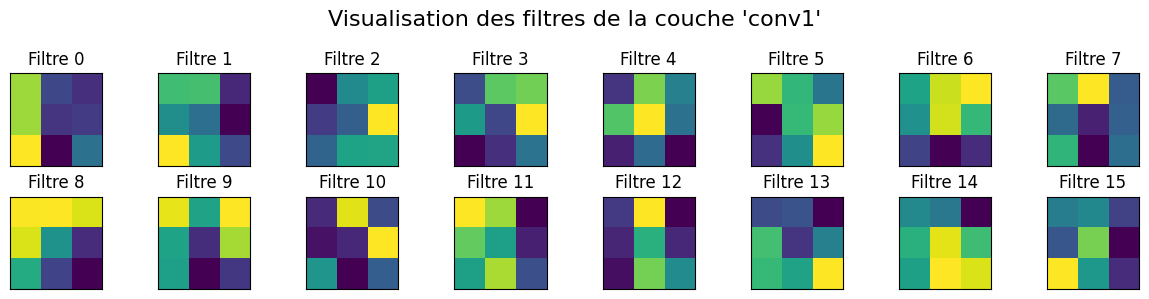

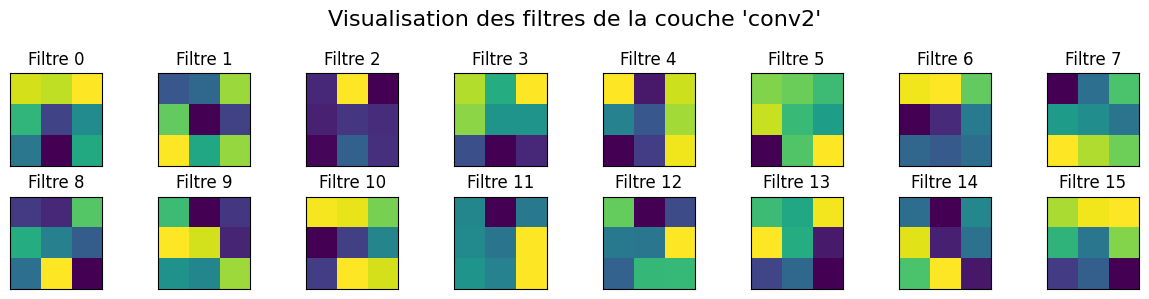

In [31]:
# ======================================================
# SECTION 5 : VISUALISATION CONFIGURABLE DES FILTRES
# ======================================================
import math

def visualize_conv_filters(conv_layer, layer_name, num_filters_to_show=16):
    """
    Affiche les poids (filtres) d'une couche de convolution donnée.
    """
    # S'assurer que la couche est bien une couche de convolution
    if not isinstance(conv_layer, nn.Conv2d):
        print(f"La couche '{layer_name}' n'est pas une couche Conv2d.")
        return

    # Extraire les poids et les préparer pour l'affichage
    weights = conv_layer.weight.detach().cpu()
    
    num_filters = min(weights.shape[0], num_filters_to_show)
    
    # Calculer dynamiquement la grille
    num_cols = 8
    num_rows = math.ceil(num_filters / num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.5, num_rows * 1.5))
    axes = axes.flatten() # Aplatir pour une itération simple

    for i in range(num_filters):
        # Normaliser chaque filtre pour un meilleur contraste visuel
        kernel = weights[i]
        kernel_min, kernel_max = kernel.min(), kernel.max()
        kernel_normalized = (kernel - kernel_min) / (kernel_max - kernel_min)
        
        # Afficher le premier canal du filtre normalisé
        axes[i].imshow(kernel_normalized[0], cmap='viridis')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Filtre {i}")

    # Cacher les sous-graphes inutilisés
    for i in range(num_filters, len(axes)):
        axes[i].axis('off')
        
    fig.suptitle(f"Visualisation des filtres de la couche '{layer_name}'", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Utilisation de la fonction ---
# Utiliser le modèle CNN déjà défini dans le notebook (cnn_model).
# Les couches convolutives sont dans cnn_model.feature_extractor,
# aux indices 0 et 3 dans l'architecture actuelle.
visualize_conv_filters(cnn_model.feature_extractor[0], "conv1")
visualize_conv_filters(cnn_model.feature_extractor[3], "conv2")

In [73]:
# ======================================================
# SECTION 6 : RAPPORT D'ARCHITECTURE PERSONNALISÉ
# ======================================================
def print_model_report(model):
    """Affiche un rapport détaillé sur les couches et les paramètres d'un modèle."""
    
    print("\n" + "┌" + "─"*90 + "┐")
    print("│" + "RAPPORT D'ARCHITECTURE DU RÉSEAU".center(78) + "            │")
    print("├" + "─"*22 + "┬" + "─"*22 + "┬" + "─"*44 + "┤")
    print(f"│ {'NOM DE LA COUCHE':<20} │ {'TYPE DE COUCHE':<20} │ {'DÉTAILS':<36}       │")
    print("├" + "─"*22 + "┼" + "─"*22 + "┼" + "─"*44 + "┤")
    
    total_trainable_params = 0
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            total_trainable_params += params
            
            layer_type = module.__class__.__name__
            details = ""
            if isinstance(module, nn.Conv2d):
                details = f"Filtres: {module.out_channels}, Noyau: {module.kernel_size}, Params: {params:,}"
            elif isinstance(module, nn.Linear):
                details = f"Entrée: {module.in_features}, Sortie: {module.out_features}, Params: {params:,}"
            
            print(f"│ {name:<20} │ {layer_type:<20} │ {details:<36}    │")

    print("└" + "─"*22 + "┴" + "─"*22 + "┴" + "─"*44 + "┘")
    print(f"  Nombre total de paramètres entraînables : {total_trainable_params:,}")
    print("─"*91)

# --- Utilisation de la fonction ---
# Sélectionner un modèle existant dans le notebook de façon robuste.
# Priorité : cnn_model (CIFAR), sinon classifier_model (MNIST), sinon 'model' si défini.
if 'cnn_model' in globals():
    target_model = globals()['cnn_model']
elif 'classifier_model' in globals():
    target_model = globals()['classifier_model']
elif 'model' in globals():
    target_model = globals()['model']
else:
    raise NameError("Aucun modèle disponible: définissez 'cnn_model', 'classifier_model' ou 'model' avant d'appeler print_model_report.")

print_model_report(target_model)


┌──────────────────────────────────────────────────────────────────────────────────────────┐
│                       RAPPORT D'ARCHITECTURE DU RÉSEAU                                   │
├──────────────────────┬──────────────────────┬────────────────────────────────────────────┤
│ NOM DE LA COUCHE     │ TYPE DE COUCHE       │ DÉTAILS                                    │
├──────────────────────┼──────────────────────┼────────────────────────────────────────────┤
│ feature_extractor.0  │ Conv2d               │ Filtres: 16, Noyau: (3, 3), Params: 448    │
│ feature_extractor.3  │ Conv2d               │ Filtres: 32, Noyau: (3, 3), Params: 4,640    │
│ classifier.1         │ Linear               │ Entrée: 2048, Sortie: 128, Params: 262,272    │
│ classifier.3         │ Linear               │ Entrée: 128, Sortie: 10, Params: 1,290    │
└──────────────────────┴──────────────────────┴────────────────────────────────────────────┘
  Nombre total de paramètres entraînables : 268,650
─────────────

### **Reformulations pour l'Évolution de la Perte (Loss):**

- *Performance d'apprentissage :* Le modèle a démontré un apprentissage constant et efficace, comme l'atteste la chute significative de la perte de 1.45 à 0,46 en dix époques.

- *Stabilité de l'entraînement :* La courbe de descente régulière, sans plateau ni instabilité, confirme que les hyperparamètres, notamment le taux d'apprentissage de l'optimiseur Adam, étaient bien adaptés à la tâche.

### **Reformulations pour la Précision Finale:**
- *Performance de généralisation :* Face à des données inconnues, le modèle a atteint une précision de 69.81 %, démontrant sa capacité à appliquer ce qu'il a appris.

- *Validation de l'architecture :* Ce score est un résultat très encourageant et solide pour un réseau aussi simple, confirmant que même une architecture CNN de base peut extraire des caractéristiques pertinentes du jeu de données CIFAR-10.